In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

data= pd.read_excel('C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//code//Dataset//Similarity_with_EMP_data.xlsx')



In [3]:
data=data[data['Department']=='Data and AI']

In [4]:
data.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Total Experience in Years,Number of Goal Assigned,Number of Goals Achieved,Final Score,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score
0,EMP9004,0.257062,0.667620,0.468664,0.573545,Male,41,Data and AI,Data Scientist,Senior,...,19,10,7,35.000000,70.000000,34.180251,76.488103,7.08,51.806653,55.141563
1,EMP9005,0.171806,0.543745,0.468005,0.648808,Female,33,Data and AI,Data Engineer,Mid-Level,...,11,10,5,35.000000,50.000000,30.775600,63.895969,1.63,40.425636,54.988743
2,EMP9009,0.237569,0.667620,0.509374,0.675198,Male,35,Data and AI,Data Scientist,Mid-Level,...,13,7,3,35.000000,42.857143,20.708582,57.979997,8.01,30.443135,36.977535
3,EMP9015,0.253079,0.646303,0.453373,0.634185,Male,42,Data and AI,Data Scientist,Senior,...,20,10,5,35.000000,50.000000,18.998407,66.495545,5.71,43.893732,45.595596
4,EMP9021,0.163569,0.646303,0.418016,0.721195,Male,59,Data and AI,Data Analyst,Expert,...,37,15,11,56.717347,73.333333,32.126666,78.174790,2.63,61.771810,50.283365


In [5]:
employee_ids =data["EmployeeCode"]

data= data.drop(columns=["EmployeeCode"])

In [6]:
un_col=['Gender','Department', 'JobCategory', 'ProficiencyLevel',
       'Education Qualifications', 'Professional Qualifications','Final Score','Age','List of Software Skills','Number of Goal Assigned', 'Number of Goals Achieved','Projects Completed',"Total Experience in Years","Absentism Rate"]
df=data.drop(columns=un_col)

In [7]:
df.head()

,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Years of Experience in this Company,KPI,Employee Satisfaction Score,Experience in Years Previous Positions,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score
0,0.257062,0.667620,0.468664,0.573545,5,38.865258,82.68,14,70.000000,34.180251,76.488103,7.08,51.806653,55.141563
1,0.171806,0.543745,0.468005,0.648808,6,37.089484,68.07,5,50.000000,30.775600,63.895969,1.63,40.425636,54.988743
2,0.237569,0.667620,0.509374,0.675198,2,30.000000,82.60,11,42.857143,20.708582,57.979997,8.01,30.443135,36.977535
3,0.253079,0.646303,0.453373,0.634185,2,31.188340,72.13,18,50.000000,18.998407,66.495545,5.71,43.893732,45.595596
4,0.163569,0.646303,0.418016,0.721195,14,52.928402,96.43,23,73.333333,32.126666,78.174790,2.63,61.771810,50.283365


In [8]:
# Normalize numerical data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [9]:
# Split into train/test sets
X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=SEED)

In [10]:
# # Define Autoencoder Model
# input_dim = X_train.shape[1]
# encoding_dim = 9  # Latent space

# input_layer = Input(shape=(input_dim,))
# encoded = Dense(12, activation='relu')(input_layer)
# encoded = Dense(encoding_dim, activation='relu')(encoded)
# decoded = Dense(12, activation='relu')(encoded)
# decoded = Dense(input_dim, activation='sigmoid')(decoded)

# autoencoder = Model(input_layer, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Train Autoencoder
# autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, shuffle=True, validation_data=(X_test, X_test))

# # Extract Encoder Model
# encoder = Model(input_layer, encoded)

# # Generate latent space representation (Employee Scores)
# employee_scores = encoder.predict(scaled_data)

# # Add latent score to dataset
# for i in range(encoding_dim):
#     data[f'LatentFeature_{i+1}'] = employee_scores[:, i]


In [11]:

from keras.regularizers import l2, l1
import keras_tuner as kt

def build_autoencoder(hp):
    input_dim = X_train.shape[1]
    encoding_dim = hp.Int("encoding_dim", min_value=2, max_value=max(4, input_dim // 2), step=1)  # Reduced max_value

    # Regularization strength hyperparameters (more conservative range)
    l2_reg = hp.Float("l2_reg", min_value=1e-6, max_value=1e-4, sampling="log")
    dropout_rate = hp.Float("dropout_rate", min_value=0.05, max_value=0.2, step=0.05)
    l1_reg = hp.Float("l1_reg", min_value=1e-6, max_value=1e-4, sampling="log")  # Sparsity regularization

    input_layer = Input(shape=(input_dim,))

    # First hidden layer with L2 regularization and dropout
    # Fewer units in the first layer
    encoded = Dense(hp.Int("units1", min_value=4, max_value=32, step=4),
                    activation=hp.Choice("activation1", ["relu", "tanh"]),
                    kernel_regularizer=l2(l2_reg))(input_layer)
    encoded = Dropout(dropout_rate)(encoded)

    # Latent space with L1 sparsity constraint
    encoded = Dense(encoding_dim, activation="relu", activity_regularizer=l1(l1_reg))(encoded)

    # Decoder with L2 regularization and dropout
    # Simpler decoder
    decoded = Dense(hp.Int("units2", min_value=4, max_value=32, step=4),
                    activation=hp.Choice("activation2", ["relu", "tanh"]),
                    kernel_regularizer=l2(l2_reg))(encoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
                        loss="mse")

    return autoencoder

# Hyperparameter tuning with Keras Tuner
tuner = kt.RandomSearch(
    build_autoencoder,
    objective="val_loss",
    max_trials=5,  # Fewer trials to prevent excessive fitting to the small dataset
    executions_per_trial=1,  # Reduce the number of executions to minimize variance effects
    directory="autoencoder_tuning",
    project_name="employee_autoencoder",
    seed=SEED
)

# Search for the best hyperparameters
tuner.search(X_train, X_train, epochs=20, batch_size=8, validation_data=(X_test, X_test))




Reloading Tuner from autoencoder_tuning\employee_autoencoder\tuner0.json


In [12]:
#Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Encoding Dim: {best_hps.get('encoding_dim')}")
print(f"Best Layer 1 Units: {best_hps.get('units1')}, Activation: {best_hps.get('activation1')}")
print(f"Best Layer 2 Units: {best_hps.get('units2')}, Activation: {best_hps.get('activation2')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

# Train Autoencoder with best hyperparameters
best_autoencoder = tuner.hypermodel.build(best_hps)
history = best_autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Extract Encoder Model
encoder = Model(best_autoencoder.input, best_autoencoder.layers[1].output)  # Extract latent space representation

# Generate latent space representation (Employee Scores)
employee_scores = encoder.predict(scaled_data)
# Get the best hyperparameters

reconstruction_error=best_autoencoder.predict(scaled_data)


Best Encoding Dim: 5


Best Layer 1 Units: 32, Activation: relu
Best Layer 2 Units: 20, Activation: relu
Best Learning Rate: 0.0005
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0767 - val_loss: 0.0798
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0763 - val_loss: 0.0793
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0755 - val_loss: 0.0784
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0745 - val_loss: 0.0770
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0729 - val_loss: 0.0754
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0713 - val_loss: 0.0736
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0694 - val_loss: 0.0717
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0680 - val_loss: 0.0696
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0661 - val_loss: 0.0677
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0646 - val_loss: 0.0662
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0

In [13]:
# # Add latent features to dataset
for i in range(best_hps.get('encoding_dim')):
    data[f'LatentFeature_{i+1}'] = employee_scores[:, i]



     
# # Save preprocessed data with latent features
# df.to_excel("employee_autoencoder_scores.xlsx", index=False)

# Save models and scaler
# best_autoencoder.save("best_autoencoder_model.h5")
# encoder.save("encoder_model.h5")
# import joblib
# joblib.dump(scaler, "scaler.pkl")

In [14]:
# pip install keras_tuner


In [15]:
data.head()

,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,Education Qualifications,...,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,LatentFeature_1,LatentFeature_2,LatentFeature_3,LatentFeature_4,LatentFeature_5
0,0.257062,0.667620,0.468664,0.573545,Male,41,Data and AI,Data Scientist,Senior,"Bachelor of Statistics, Master of Data Analytics",...,34.180251,76.488103,7.08,51.806653,55.141563,0.0,1.046539,0.873150,0.973299,0.0
1,0.171806,0.543745,0.468005,0.648808,Female,33,Data and AI,Data Engineer,Mid-Level,Bachelor of Science,...,30.775600,63.895969,1.63,40.425636,54.988743,0.0,0.675821,0.644842,0.951802,0.0
2,0.237569,0.667620,0.509374,0.675198,Male,35,Data and AI,Data Scientist,Mid-Level,"Bachelor of Data Science, Master of Data Science",...,20.708582,57.979997,8.01,30.443135,36.977535,0.0,0.683192,0.691335,0.979649,0.0
3,0.253079,0.646303,0.453373,0.634185,Male,42,Data and AI,Data Scientist,Senior,"Bachelor of Applied Statistics, Master of Data...",...,18.998407,66.495545,5.71,43.893732,45.595596,0.0,0.704149,0.710396,0.908524,0.0
4,0.163569,0.646303,0.418016,0.721195,Male,59,Data and AI,Data Analyst,Expert,"Bachelor of Data Science, Master of Data Scien...",...,32.126666,78.174790,2.63,61.771810,50.283365,0.0,1.559702,1.138839,1.193806,0.0


In [16]:
data[[f'LatentFeature_{i+1}' for i in range(best_hps.get('encoding_dim'))]].head()


,LatentFeature_1,LatentFeature_2,LatentFeature_3,LatentFeature_4,LatentFeature_5
0,0.0,1.046539,0.873150,0.973299,0.0
1,0.0,0.675821,0.644842,0.951802,0.0
2,0.0,0.683192,0.691335,0.979649,0.0
3,0.0,0.704149,0.710396,0.908524,0.0
4,0.0,1.559702,1.138839,1.193806,0.0


In [17]:
data['SuitabilityScore_AE'] = np.abs(data[[f'LatentFeature_{i+1}' for i in range(best_hps.get('encoding_dim'))]]).mean(axis=1)
data['SuitabilityScore_AE_scaled']=scaler.fit_transform(data[['SuitabilityScore_AE']])
latent_features=data[[f'LatentFeature_{i+1}' for i in range(best_hps.get('encoding_dim'))]]
data['SuitabilityScore_AE_norm'] = np.linalg.norm(latent_features, axis=1)
data['SuitabilityScore_AE_norm_scale'] =scaler.fit_transform(data[['SuitabilityScore_AE_norm']])
data['SuitabilityScore_AE_var'] = latent_features.var(axis=1)
data['SuitabilityScore_AE_var_scale'] =scaler.fit_transform(data[['SuitabilityScore_AE_var']])


In [18]:
df1=pd.read_excel("C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//code//Dataset//Jd_score.xlsx")
df3=pd.read_excel("C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//code//Dataset//PCA_scores.xlsx")
df1=df1[['EmployeeCode','JD match Score']]
df1['Job_disimilarity']=1-df1['JD match Score']
df3=df3[['EmployeeCode','Suitability_score_scaled_PCA']]


In [19]:
dfAE = pd.concat([employee_ids.reset_index(drop=True), data], axis=1)


In [20]:
dfAE=dfAE[['EmployeeCode','SuitabilityScore_AE_norm_scale']]
Suitability_Scores=df1.merge(df3,on='EmployeeCode')
Suitability_Scores=Suitability_Scores.merge(dfAE,on='EmployeeCode')
Suitability_Scores.to_excel("abc.xlsx",index=False)

In [21]:
dfAE.sort_values('SuitabilityScore_AE_norm_scale',ascending=False).head(10)

,EmployeeCode,SuitabilityScore_AE_norm_scale
90,EMP9428,1.000000
6,EMP9023,0.965802
45,EMP9217,0.939994
19,EMP9091,0.938222
55,EMP9283,0.922130
232,EMP9966,0.908988
4,EMP9021,0.902310
137,EMP9616,0.894213
20,EMP9092,0.878281
26,EMP9128,0.863344


In [22]:
dfAE.to_excel('C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//code//Dataset//Autoencoder_score.xlsx')

In [23]:
Suitability_Scores.columns

Index(['EmployeeCode', 'JD match Score', 'Job_disimilarity',
       'Suitability_score_scaled_PCA', 'SuitabilityScore_AE_norm_scale'],
      dtype='object')

In [24]:
# Suitability_Scores['Energy Score'] = ranked_data['Energy Score']

# # Compute correlation matrix
# correlation_matrix = Suitability_Scores[['Job_disimilarity', 'Suitability_score_scaled_PCA', 
#                                          'SuitabilityScore_AE_scaled', 'Energy Score']].corr()
# print(correlation_matrix)

In [25]:
Suitability_Scores[['Job_disimilarity','Suitability_score_scaled_PCA','SuitabilityScore_AE_norm_scale' ]].corr()

,Job_disimilarity,Suitability_score_scaled_PCA,SuitabilityScore_AE_norm_scale
Job_disimilarity,1.000000,-0.165347,-0.241716
Suitability_score_scaled_PCA,-0.165347,1.000000,0.793248
SuitabilityScore_AE_norm_scale,-0.241716,0.793248,1.000000


In [26]:
Suitability_Scores[['EmployeeCode','Job_disimilarity','Suitability_score_scaled_PCA', 'SuitabilityScore_AE_norm_scale']].to_excel(
    "C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//code//Dataset//Both_Approches.xlsx",index=False)

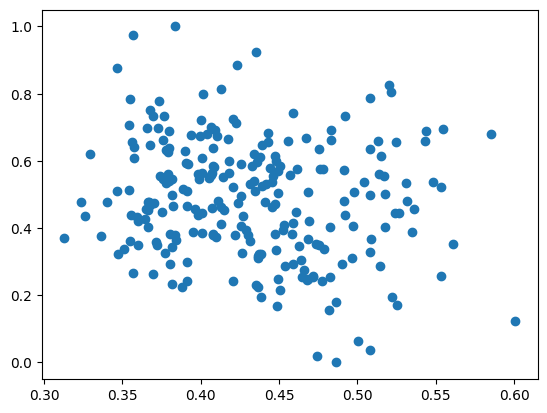

In [27]:
import matplotlib.pyplot as plt
plt.scatter(Suitability_Scores['Job_disimilarity'],Suitability_Scores['Suitability_score_scaled_PCA'])

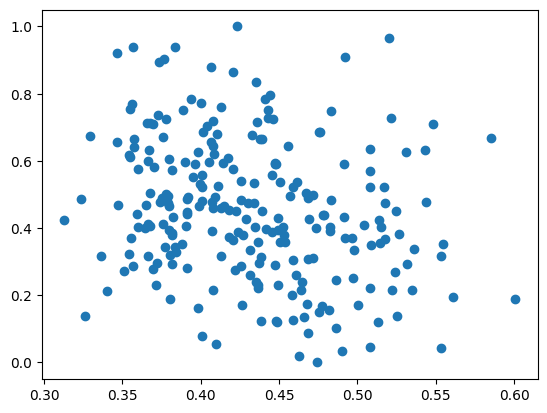

In [32]:
plt.scatter(Suitability_Scores['Job_disimilarity'],Suitability_Scores['SuitabilityScore_AE_norm_scale'])

In [28]:

#  Ensure feature names exist
if isinstance(df, pd.DataFrame):
    feature_names = df.columns.tolist()  # Get actual column names
else:
    raise ValueError("df must be a Pandas DataFrame to retrieve actual column names.")

#  Identify the first Dense layer in the encoder
dense_layers = [layer for layer in encoder.layers if isinstance(layer, Dense)]
if not dense_layers:
    raise ValueError("No Dense layers found in the encoder. Check your model structure.")

first_dense_layer = dense_layers[0]  # Get the first Dense layer

#  Extract encoder weights
encoder_weights = first_dense_layer.get_weights()[0]  # First dense layer weights

#  Ensure weight dimensions match the number of features
if encoder_weights.shape[0] != len(feature_names):
    raise ValueError(f"Mismatch: Encoder weights have {encoder_weights.shape[0]} inputs, "
                     f"but feature names list has {len(feature_names)} features.")

# Compute feature importance as the sum of absolute weights
feature_importance = np.sum(np.abs(encoder_weights), axis=1)

#  Create a DataFrame with feature names and importance values
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
})

# Sort features by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display the most influential features
print(feature_importance_df)


                                   Feature  Importance
10                    Cultural Value Score    6.467530
7   Experience in Years Previous Positions    6.027079
5                                      KPI    5.963151
6              Employee Satisfaction Score    5.806625
0                       Technical Score_JD    5.712543
2                       Soft Score_with_JD    5.689128
1                     Programming Score_JD    5.674749
4      Years of Experience in this Company    5.671709
3            Education_match_Score_with_JD    5.576769
9                         Competency Score    5.360350
8                              Goals Score    5.078699
12              Potential Assessment Score    4.634314
11         Additional Accomplishment Score    4.556458
13                  Trait Assessment Score    4.426793


In [29]:
# X_test_pred = best_autoencoder.predict(X_test)

# baseline_loss = np.mean(np.square(X_test - X_test_pred), axis=0)

# # Feature importance via reconstruction loss increase
# feature_importance = {}
# input_dim = X_train.shape[1]
# for i in range(input_dim):
#     X_test_masked = X_test.copy()
#     X_test_masked[:, i] = 0  # Mask one feature at a time
#     X_test_pred_masked = best_autoencoder.predict(X_test_masked)
#     masked_loss = np.mean(np.square(X_test - X_test_pred_masked), axis=0)
#     feature_importance[f'Feature_{i+1}'] = np.mean(masked_loss - baseline_loss)

# # Convert feature importance to a sorted DataFrame
# feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)

feature_names = df.columns.tolist()

# Compute baseline reconstruction error
X_test_pred = best_autoencoder.predict(X_test)
baseline_loss = np.mean(np.square(X_test - X_test_pred), axis=0)

# Feature importance via reconstruction loss increase
feature_importance = {}
input_dim = X_train.shape[1]
for i in range(input_dim):
    X_test_masked = X_test.copy()
    X_test_masked[:, i] = 0  # Mask one feature at a time
    X_test_pred_masked = best_autoencoder.predict(X_test_masked)
    masked_loss = np.mean(np.square(X_test - X_test_pred_masked), axis=0)
    feature_importance[feature_names[i]] = np.mean(masked_loss - baseline_loss)

# Convert feature importance to a sorted DataFrame
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the results
print(feature_importance_df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
                                        Importance
Programming Score_JD                      0.005759
Years of Experience in this Company       0.004359
Potential Assessment Score                0.002303
Soft Score_with_JD                        0.002195
KPI                                       0.002065
Technical Score_JD                        0.002039
Cultural Value Score                      0.001584
Competency Score    

In [30]:
X_test_pred = best_autoencoder.predict(X_test)

# Compute Reconstruction Error
reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
reconstruction_errors = np.mean((X_test - X_test_pred) ** 2, axis=1)

# Print average error
print(f"Average Reconstruction Error: {np.mean(reconstruction_errors)}")

# Display error values
print("Reconstruction Errors:", np.mean(reconstruction_error))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Average Reconstruction Error: 0.047355734856578326
Reconstruction Errors: 0.047355734856578326


In [31]:
from sklearn.metrics import mean_absolute_error

# Compute Reconstruction Error with MAE
reconstruction_error_mae = np.mean(np.abs(X_test - X_test_pred), axis=1)

print("Reconstruction Errors (MAE):", np.mean(reconstruction_error_mae))


Reconstruction Errors (MAE): 0.17473637011375878
